In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Load the diamond dataset
df = pd.read_csv('/content/train.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

Dataset loaded successfully!
Dataset shape: (193573, 11)


In [3]:
print("First 5 records:")
df.head()

First 5 records:


,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


In [4]:
print("\nDataset Info:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())

print("\nBasic statistics:")
df.describe()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193573 non-null  int64  
 1   carat    193573 non-null  float64
 2   cut      193573 non-null  object 
 3   color    193573 non-null  object 
 4   clarity  193573 non-null  object 
 5   depth    193573 non-null  float64
 6   table    193573 non-null  float64
 7   x        193573 non-null  float64
 8   y        193573 non-null  float64
 9   z        193573 non-null  float64
 10  price    193573 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 16.2+ MB

Missing values:
id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

Basic statistics:


,id,carat,depth,table,x,y,z,price
count,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000
mean,96786.000000,0.790688,61.820574,57.227675,5.715312,5.720094,3.534246,3969.155414
std,55879.856166,0.462688,1.081704,1.918844,1.109422,1.102333,0.688922,4034.374138
min,0.000000,0.200000,52.100000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,48393.000000,0.400000,61.300000,56.000000,4.700000,4.710000,2.900000,951.000000
50%,96786.000000,0.700000,61.900000,57.000000,5.700000,5.720000,3.530000,2401.000000
75%,145179.000000,1.030000,62.400000,58.000000,6.510000,6.510000,4.030000,5408.000000
max,193572.000000,3.500000,71.600000,79.000000,9.650000,10.010000,31.300000,18818.000000


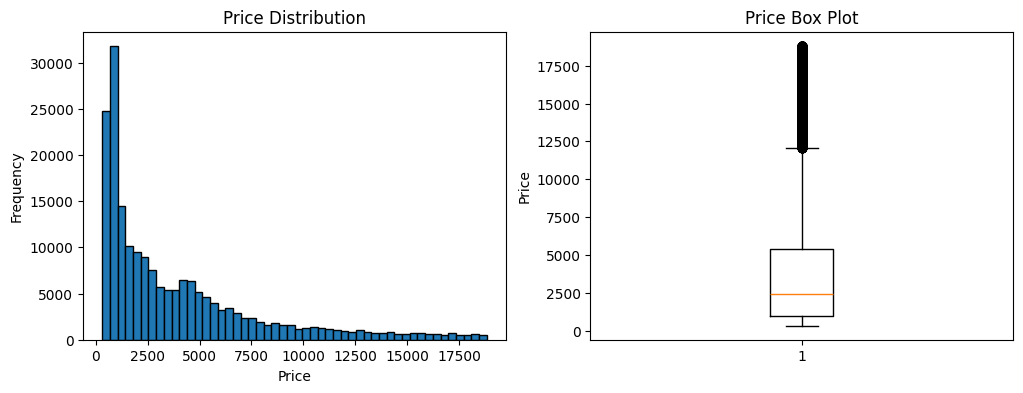

In [5]:
## Check Target Variable Distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=50, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(df['price'])
plt.title('Price Box Plot')
plt.ylabel('Price')
plt.show()

In [6]:
## Prepare Features and Target
if 'id' in df.columns:
    X = df.drop(['price', 'id'], axis=1)
else:
    X = df.drop(['price'], axis=1)

y = df['price']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Features: {list(X.columns)}")

Features shape: (193573, 9)
Target shape: (193573,)
Features: ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']


In [7]:
## Identify Categorical and Numerical Columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['cut', 'color', 'clarity']
Numerical columns: ['carat', 'depth', 'table', 'x', 'y', 'z']


In [8]:
## Check Unique Values in Categorical Columns
for col in categorical_cols:
    print(f"\n{col} unique values: {df[col].unique()}")

## Define Categories for Ordinal Encoding
cut_categories = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_categories = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_categories = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']


cut unique values: ['Premium' 'Very Good' 'Ideal' 'Good' 'Fair']

color unique values: ['F' 'J' 'G' 'E' 'D' 'H' 'I']

clarity unique values: ['VS2' 'SI2' 'VS1' 'SI1' 'IF' 'VVS2' 'VVS1' 'I1']


In [9]:
## Create Preprocessing Pipeline
num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

# Categorical pipeline
cat_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal_encoder', OrdinalEncoder(categories=[cut_categories, color_categories, clarity_categories])),
        ('scaler', StandardScaler())
    ]
)

# Combined preprocessor
preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, numerical_cols),
    ('cat_pipeline', cat_pipeline, categorical_cols)
])

print("Preprocessing pipeline created successfully!")

Preprocessing pipeline created successfully!


In [10]:
## Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (154858, 9)
Test set size: (38715, 9)


In [11]:
##  Apply Preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Data preprocessing completed!")
print(f"Processed training set shape: {X_train_processed.shape}")
print(f"Processed test set shape: {X_test_processed.shape}")

Data preprocessing completed!
Processed training set shape: (154858, 9)
Processed test set shape: (38715, 9)


In [12]:
## Model Evaluation Function
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [13]:
##  Define Models for Training
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'KNN': KNeighborsRegressor()
}

print(f"Number of models to train: {len(models)}")

Number of models to train: 10


In [14]:
## Train and Evaluate Models
model_results = []

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Train the model
    model.fit(X_train_processed, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)

    # Evaluate on training set
    mae_train, mse_train, rmse_train, r2_train = evaluate_model(y_train, y_train_pred)

    # Evaluate on test set
    mae_test, mse_test, rmse_test, r2_test = evaluate_model(y_test, y_test_pred)

    # Store results
    model_results.append({
        'Model': model_name,
        'Train_MAE': mae_train,
        'Train_RMSE': rmse_train,
        'Train_R2': r2_train,
        'Test_MAE': mae_test,
        'Test_RMSE': rmse_test,
        'Test_R2': r2_test
    })

    # Print results
    print(f"{model_name} Results:")
    print("Training Performance:")
    print(f"  RMSE: {rmse_train:.4f}")
    print(f"  MAE: {mae_train:.4f}")
    print(f"  R2 Score: {r2_train:.4f}")
    print("Test Performance:")
    print(f"  RMSE: {rmse_test:.4f}")
    print(f"  MAE: {mae_test:.4f}")
    print(f"  R2 Score: {r2_test:.4f}")
    print("=" * 50)


Training Linear Regression...
Linear Regression Results:
Training Performance:
  RMSE: 1016.9490
  MAE: 677.1656
  R2 Score: 0.9366
Test Performance:
  RMSE: 1006.6010
  MAE: 671.5856
  R2 Score: 0.9373

Training Lasso...
Lasso Results:
Training Performance:
  RMSE: 1017.0718
  MAE: 678.3145
  R2 Score: 0.9366
Test Performance:
  RMSE: 1006.8716
  MAE: 672.8635
  R2 Score: 0.9373

Training Ridge...
Ridge Results:
Training Performance:
  RMSE: 1016.9491
  MAE: 677.1925
  R2 Score: 0.9366
Test Performance:
  RMSE: 1006.6062
  MAE: 671.6137
  R2 Score: 0.9373

Training ElasticNet...
ElasticNet Results:
Training Performance:
  RMSE: 1538.1402
  MAE: 1065.2238
  R2 Score: 0.8549
Test Performance:
  RMSE: 1535.5944
  MAE: 1063.3298
  R2 Score: 0.8541

Training Decision Tree...
Decision Tree Results:
Training Performance:
  RMSE: 12.8816
  MAE: 0.8012
  R2 Score: 1.0000
Test Performance:
  RMSE: 834.9517
  MAE: 423.5820
  R2 Score: 0.9569

Training Random Forest...
Random Forest Results:
Tra

In [15]:
## Results Summary
results_df = pd.DataFrame(model_results)
results_df_sorted = results_df.sort_values(by='Test_R2', ascending=False)

print("\nModel Performance Summary (Sorted by Test R2 Score):")
print(results_df_sorted.round(4))


Model Performance Summary (Sorted by Test R2 Score):
               Model  Train_MAE  Train_RMSE  Train_R2   Test_MAE  Test_RMSE  \
6            XGBoost   275.7584    514.2452    0.9838   296.9582   585.4372   
5      Random Forest   115.9516    228.1711    0.9968   309.0089   607.1910   
8  Gradient Boosting   330.6408    612.6186    0.9770   331.4019   621.0152   
9                KNN   285.8174    545.6521    0.9817   349.4827   671.2933   
4      Decision Tree     0.8012     12.8816    1.0000   423.5820   834.9517   
0  Linear Regression   677.1656   1016.9490    0.9366   671.5856  1006.6010   
2              Ridge   677.1925   1016.9491    0.9366   671.6137  1006.6062   
1              Lasso   678.3145   1017.0718    0.9366   672.8635  1006.8716   
7           AdaBoost  1063.1817   1482.6741    0.8652  1065.5770  1491.6385   
3         ElasticNet  1065.2238   1538.1402    0.8549  1063.3298  1535.5944   

   Test_R2  
6   0.9788  
5   0.9772  
8   0.9761  
9   0.9721  
4   0.9569 

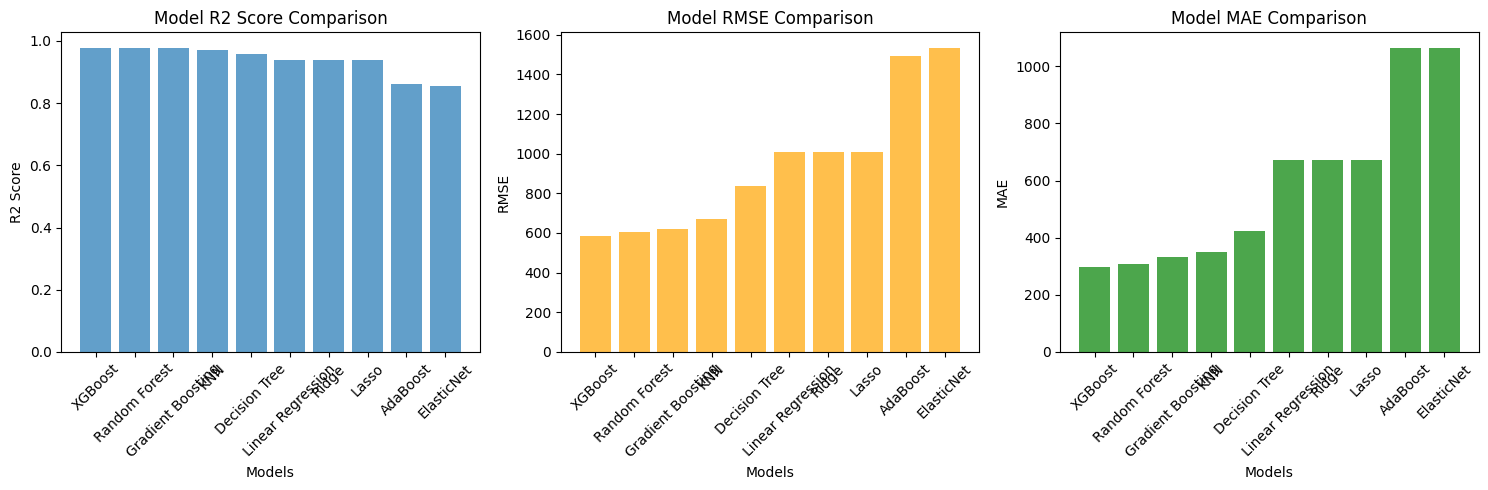

In [16]:
## Visualize Model Performance
plt.figure(figsize=(15, 5))

# R2 Score comparison
plt.subplot(1, 3, 1)
x_pos = range(len(results_df_sorted))
plt.bar(x_pos, results_df_sorted['Test_R2'], alpha=0.7)
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.title('Model R2 Score Comparison')
plt.xticks(x_pos, results_df_sorted['Model'], rotation=45)

# RMSE comparison
plt.subplot(1, 3, 2)
plt.bar(x_pos, results_df_sorted['Test_RMSE'], alpha=0.7, color='orange')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Model RMSE Comparison')
plt.xticks(x_pos, results_df_sorted['Model'], rotation=45)

# MAE comparison
plt.subplot(1, 3, 3)
plt.bar(x_pos, results_df_sorted['Test_MAE'], alpha=0.7, color='green')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.title('Model MAE Comparison')
plt.xticks(x_pos, results_df_sorted['Model'], rotation=45)

plt.tight_layout()
plt.show()

In [17]:
## Best Model Analysis
best_model_name = results_df_sorted.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Test R2 Score: {results_df_sorted.iloc[0]['Test_R2']:.4f}")
print(f"Test RMSE: {results_df_sorted.iloc[0]['Test_RMSE']:.4f}")
print(f"Test MAE: {results_df_sorted.iloc[0]['Test_MAE']:.4f}")


Best Model: XGBoost
Test R2 Score: 0.9788
Test RMSE: 585.4372
Test MAE: 296.9582


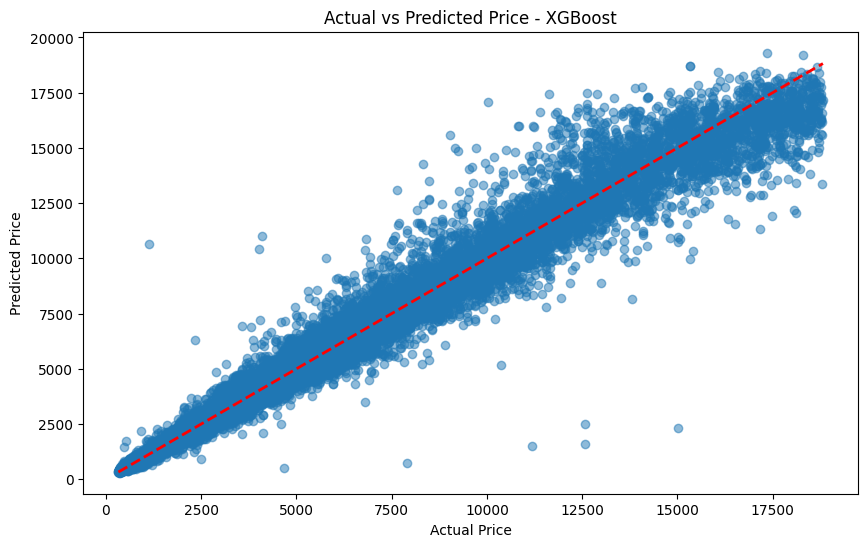

In [18]:
## Prediction vs Actual Plot for Best Model
best_model_pred = best_model.predict(X_test_processed)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_model_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Actual vs Predicted Price - {best_model_name}')
plt.show()

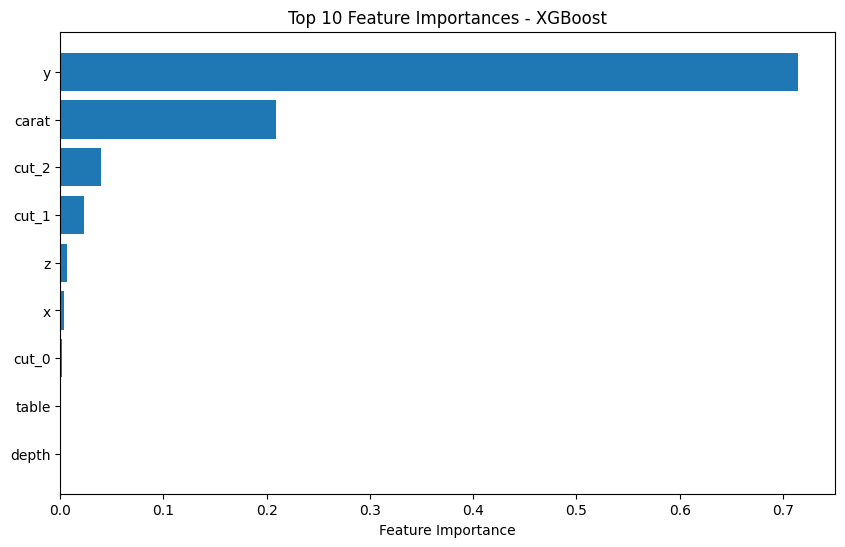


Model training completed successfully!


In [19]:
## Feature Importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_names = (numerical_cols +
                    [f'cut_{i}' for i in range(len(cut_categories))] +
                    [f'color_{i}' for i in range(len(color_categories))] +
                    [f'clarity_{i}' for i in range(len(clarity_categories))])

    feature_importance = pd.DataFrame({
        'feature': feature_names[:len(best_model.feature_importances_)],
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.show()

print("\nModel training completed successfully!")

In [20]:
import pickle
import os
from google.colab import files

os.makedirs('artifacts', exist_ok=True)

with open('artifacts/model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('artifacts/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

print("Model and preprocessor saved successfully!")

files.download('artifacts/model.pkl')
files.download('artifacts/preprocessor.pkl')

Model and preprocessor saved successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
import joblib
from sklearn import __version__ as sklearn_version

print(f"Scikit-learn version: {sklearn_version}")

joblib.dump(best_model, 'artifacts/model.joblib')
joblib.dump(preprocessor, 'artifacts/preprocessor.joblib')

with open('artifacts/model_v4.pkl', 'wb') as f:
    pickle.dump(best_model, f, protocol=4)

with open('artifacts/preprocessor_v4.pkl', 'wb') as f:
    pickle.dump(preprocessor, f, protocol=4)

model_info = {
    'sklearn_version': sklearn_version,
    'model_type': type(best_model).__name__,
    'features': list(X.columns),
    'categorical_features': categorical_cols,
    'numerical_features': numerical_cols
}

with open('artifacts/model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("Models saved with compatibility options!")

files.download('artifacts/model.joblib')
files.download('artifacts/preprocessor.joblib')
files.download('artifacts/model_v4.pkl')
files.download('artifacts/preprocessor_v4.pkl')
files.download('artifacts/model_info.pkl')

Scikit-learn version: 1.6.1
Models saved with compatibility options!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>